In [1]:
tfidf_words = np.load('/home/yamanishi/project/trip_recommend/data/jalan/graph/tfidf_words.npy')
tfidf_top_words = np.load('/home/yamanishi/project/trip_recommend/data/jalan/graph/tfidf_top_words.npy')
tfidf_top_words.shape

(42852, 15)

In [2]:
df_exp = pd.read_csv('/home/yamanishi/project/trip_recommend/data/jalan/spot/experience_light.csv')
spot_index = {spot:index for index, spot in enumerate(df_exp['spot_name'])}
spot_pref = {spot:pref for spot, pref in zip(df_exp['spot_name'], df_exp['prefecture'])}

LIMEの結果の読み込み

In [3]:
df_lime = pd.read_csv('/home/yamanishi/project/trip_recommend/model/popularity_final/data/lime/lime_explain_new_word.csv')[118:].reset_index()

In [4]:
spot_emb = torch.load('/home/yamanishi/project/trip_recommend/model/popularity_final/data/spot_emb_final.pt')

In [5]:
from sklearn.metrics.pairwise import cosine_similarity
cos_sim = cosine_similarity(spot_emb.cpu().detach().numpy(), spot_emb.cpu().detach().numpy())

In [8]:
spot_num = len(df_exp)
spot_names = df_exp['spot_name'].values
spot_reviewcount = {spot:review_count for spot,review_count in zip(df_exp['spot_name'], df_exp['review_count'])}
def nn_lime():
    over100 = np.array(df_exp[df_exp['review_count']>=100].index)
    spot_id = np.random.choice(over100, 1)[0]
    K=10
    cos_sim_spot = cos_sim[spot_id]
    unsorted_max_indices = np.argpartition(-cos_sim_spot, K+1)[1:K+1]

    # 上位k件の値
    y = cos_sim_spot[unsorted_max_indices]
    print(y)
    # 大きい順にソートし、インデックスを取得
    indices = np.argsort(-y)
    max_k_indices = unsorted_max_indices[indices]
    print('origin spot', spot_names[spot_id], spot_reviewcount[spot_names[spot_id]])
    neighbor_spots = spot_names[max_k_indices]
    lime_words = []
    scores = []
    for ns in neighbor_spots:
        scores.append(spot_reviewcount[ns])
        df_lime_tmp = df_lime[df_lime['spot_name'].str.contains(ns)].reset_index()
        if len(df_lime_tmp)>0:
            lime_all = []
            for i in range(15):
                lime_all.append((df_lime_tmp.loc[0, f'vocab{i}'], round(float(df_lime_tmp.loc[0, f'coef{i}']),2)))
            lime_all.sort(key=lambda x: x[1], reverse=True)
            lime_words.append(lime_all[:10])
        else:
            lime_words.append([])
    #print('neighbor spots', spot_names[max_k_indices])
    for i in range(K):
        print(neighbor_spots[i], scores[i],lime_words[i])
        
nn_lime()

[0.9999998  0.9998597  0.9998522  0.99984086 0.99979085 0.9998112
 0.99979866 0.99980885 0.99979067 0.9997793 ]
origin spot 層雲峡（北海道上川町） 849.0
層雲峡（北海道上川町） 849.0 [('北海道', 0.3), ('ライトアップ', 0.26), ('紅葉', 0.23), ('花火', 0.12), ('ウェイ', 0.11), ('ロープ', 0.07), ('リフト', 0.01), ('層雲峡', -0.0), ('瀑祭', -0.0), ('旭川', 0.0)]
流星の滝 434.0 [('迫力', 0.25), ('駐車', 0.2), ('見る', 0.18), ('紅葉', 0.15), ('流星', 0.09), ('瀑台', 0.09), ('見え', 0.08), ('凍っ', 0.06), ('水量', 0.05), ('マイナス', 0.03)]
積丹岬 402.0 [('景色', 0.26), ('天気', 0.2), ('ウニ', 0.14), ('ブルー', 0.13), ('灯台', 0.13), ('絶景', 0.12), ('小樽', 0.09), ('積丹', 0.08), ('トンネル', 0.08), ('積丹半島', 0.06)]
座間味島 424.0 [('沖縄', 0.3), ('離島', 0.21), ('フェリー', 0.16), ('ビーチ', 0.1), ('那覇', 0.1), ('透明', 0.1), ('座間味', 0.07), ('本島', 0.06), ('シュノーケリング', 0.03), ('ウミガメ', 0.03)]
大歩危･小歩危 411.0 [('自然', 0.43), ('景色', 0.34), ('紅葉', 0.27), ('大歩危', 0.15), ('ラフティング', 0.11), ('徳島', 0.05), ('小歩危', 0.0), ('渓谷', -0.0), ('吉野川', -0.0), ('遊覧', 0.0)]
大間崎 473.0 [('食べ', 0.25), ('津軽海峡', 0.17), ('北海道', 0.15), ('青森', 0

In [5]:
df_lime[df_lime['spot_name'].str.contains('水族館')]

index                  spot_name        gt      pred  vocab0     coef0  \
6       124                   沖縄美ら海水族館  3.824841  3.189615     水族館  0.162787   
35      153                    名古屋港水族館  3.596597  3.031110     イルカ  0.244851   
87      205                      鳥羽水族館  3.432328  2.825861    ジュゴン  0.000000   
104     222                  サンシャイン水族館  3.405688  2.832371    ペンギン  0.323211   
136     254                    新江ノ島水族館  3.363988  2.925273     ショー  0.339624   
216     334        大分マリーンパレス水族館「うみたまご」  3.253096  3.115716     イルカ  0.137855   
243     361                      京都水族館  3.227887  3.053005     イルカ  0.158973   
273     391                  鶴岡市立加茂水族館  3.185542  2.818748     クラゲ  0.104783   
279     397            アクアワールド茨城県大洗水族館  3.175222  3.061101     ショー  0.311345   
301     419                     すみだ水族館  3.163161  2.781552     水族館  0.275135   
328     446                      竹島水族館  3.137987  2.934447     水族館  0.258814   
335     453    伊勢夫婦岩ふれあい水族館(伊勢シーパラダイス)  3.130334  2.941786    セイウチ  0.293268   
359     477              いおワールドかごしま水族館  3.110253  3.117316     イルカ  0.140590   
392     510           下関市立しものせき水族館・海響館  3.092721  3.175241     イルカ  0.147037   
425     543                  仙台うみの杜水族館  3.070407  2.957019     イルカ  0.166924   
471     589                    下田海中水族館  3.040207  3.159063     イルカ  0.142970   
489     607                    のとじま水族館  3.028978  3.113743  ジンベイザメ  0.193236   
496     614                    越前松島水族館  3.026533  3.057806     イルカ  0.162357   
566     684                  長崎ペンギン水族館  2.979548  3.058185    ペンギン  0.223628   
593     711              宮島水族館「みやじマリン」  2.964260  3.182356     水族館  0.190870   
653     771        世界淡水魚園水族館　アクア・トト ぎふ  2.941511  3.000051     淡水魚  0.071677   
733     851                    しながわ水族館  2.900367  2.752580     水族館  0.311231   
736     854                      浅虫水族館  2.899273  2.858667     イルカ  0.187897   
978    1096    沼津港深海水族館～シーラカンス・ミュージアム～  2.801404  2.673325  シーラカンス  0.286431   
980    1098    沼津港深海水族館〜シーラカンス・ミュージアム〜  2.801404  2.673325  シーラカンス  0.287734   
1083   1201                   男鹿水族館GAO  2.770115  3.139055     水族館  0.182775   
1170   1288                九十九島水族館海きらら  2.744293  2.909224     イルカ  0.179538   
1238   1356            新潟市水族館 マリンピア日本海  2.722634  3.139374     イルカ  0.155395   
1311   1429                     新屋島水族館  2.700704  3.326417     イルカ  0.161494   
1348   1466                   北の大地の水族館  2.691081  2.412955     水族館  0.246613   
1503   1621                     箱根園水族館  2.651278  3.193362     水族館  0.178635   
1595   1713               サケのふるさと千歳水族館  2.625312  2.524139      サケ  0.086694   
1606   1724                      桂浜水族館  2.622214  3.341709     水族館  0.160456   
1924   2042                   サンピアザ水族館  2.555094  3.209422     水族館  0.182471   
2190   2308                    京大白浜水族館  2.506505  2.112650     水族館  0.366778   
2264   2382          渋川マリン水族館（玉野海洋博物館）  2.492760  2.299192     水族館  0.286107   
2340   2458            わくわく海中水族館シードーナツ  2.478566  2.731377     イルカ  0.206755   
2710   2828                  県営さいたま水族館  2.419956  2.224535     水族館  0.225877   
2771   2889                      魚津水族館  2.411620  2.488196     水族館  0.251229   
3433   3551                   沖縄美ら海水族館  3.824841  3.131159     水族館  0.260902   
3638   3756                    姫路市立水族館  2.298853  2.627485     水族館  0.204922   
4585   4703       山梨県立富士湧水の里水族館（森の水族館）  2.170262  2.254797     水族館  0.284594   
4609   4727                    市立室蘭水族館  2.167317  2.828825     水族館  0.230474   
4695   4813                 ノシャップ寒流水族館  2.158362  2.828168    アザラシ  0.207915   
4797   4915             すさみ町立エビとカニの水族館  2.146128  1.515501      エビ  0.000000   
5985   6103                ヨコハマおもしろ水族館  2.008600  2.660819     水族館  0.250463   
6618   6736                  出の山淡水魚水族館  1.944483  2.279012     淡水魚  0.018934   
6696   6814         アクアマリンいなわしろカワセミ水族館  1.939519  2.241501     水族館  0.427520   
6963   7081              蓼科アミューズメント水族館  1.913814  1.931872     水族館  0.221767   
8835  

In [4]:
df_lime.head()

spot_name                  gt       pred   vocab0  \
118  東京ディズニーランド(R)   4.169556882432185  3.3827522  アトラクション   
119   東京ディズニーシー(R)   4.042457374574321  3.4403634  アトラクション   
120          横浜中華街   3.967875445548033  2.8171995       中華   
121            浅草寺   3.878751520173002  3.1758435      浅草寺   
122           嚴島神社  3.8524799936368566  3.0151901       厳島   

                   coef0 vocab1                coef1 vocab2  \
118  0.15413012712682383  美女と野獣   0.2271229282854267  ディズニー   
119   0.1503908784717789   ソアリン  0.19023049212325585  ディズニー   
120  0.20784207977675603     食べ  0.15907629691087974     横浜   
121  0.12875438784409862     浅草  0.15950630753597458    仲見世   
122  0.06974998595013128     鳥居  0.09370280050541399     工事   

                   coef2 vocab3  ... vocab10               coef10 vocab11  \
118  0.14394594097207017   パレード  ...      パス  0.13720897617968542    待ち時間   
119  0.12952864365654937     シー  ...    ミッキー  0.15448835855496823    待ち時間   
120  0.15838195458725882     放題  ...    オーダー                 -0.0     肉まん   
121  0.16861715330892044     雷門  ...      くじ  0.10347381918369691  ライトアップ   
122  0.08825310846985182    大鳥居  ...      干潮   0.0465305320251354      見れ   

                   coef11 vocab12                coef12 vocab13  \
118   0.07612679480804659  ファストパス   0.09014468903686325     パーク   
119  0.056290771387322885     乗り物   0.15087725936783797      パス   
120   0.07297957453424837      点心                   0.0      雑貨   
121    0.1530788346830147      通り  0.003277869434635325      着物   
122   0.06522689372065778      満潮  0.014024169635125735     御朱印   

                  coef13 vocab14                coef14  
118  0.05232940613561038      乗れ   0.06037540531955709  
119   0.1145747019986688      入場   0.10294672062590603  
120  0.08234379789567485      満足  0.010764003849957314  
121  0.05191722454631729      お寺   0.03483128043134653  
122  0.12357344343685728  ライトアップ   0.19221956705133345  

[5 rows x 33 columns]

In [2]:
from collections import defaultdict
df = pd.read_csv('/home/yamanishi/project/trip_recommend/data/jalan/spot/experience_light.csv')
spot_category = np.load('/home/yamanishi/project/trip_recommend/data/jalan/graph/spot_category.npy')
d = defaultdict(list)

In [3]:
spot_to_category = defaultdict(list)
with open('/home/yamanishi/project/trip_recommend/data/jalan/graph/index_category.pkl', 'rb') as f:
    index_category = pickle.load(f)
spot_names = df['spot_name'].values
for spot, category in zip(spot_category[0], spot_category[1]):
    spot_to_category[spot_names[spot]].append(index_category[category])

In [11]:
spot_to_category

defaultdict(list,
            {'函館山': ['自然景観・絶景', '山岳'],
             '旭山動物園': ['観光施設・名所巡り', '動物園・植物園'],
             '六花亭本店': ['ショッピング', 'その他ショッピング'],
             '神威岬': ['自然景観・絶景', '海岸景観'],
             'ニトリ観光果樹園': ['果物・野菜狩り',
              'さくらんぼ狩り',
              '果物・野菜狩り',
              '梨狩り',
              '果物・野菜狩り',
              '桃狩り',
              '果物・野菜狩り',
              'ぶどう狩り',
              '果物・野菜狩り',
              'その他果物・野菜狩り'],
             '小樽青の洞窟クルーズ': ['乗り物', 'クルーズ・クルージング'],
             '知床五湖': ['自然景観・絶景', '湖沼'],
             '北海道神宮': ['神社・神宮・寺院', 'その他神社・神宮・寺院'],
             '洞爺湖': ['自然景観・絶景', '湖沼'],
             'クランベリー本店': ['ショッピング', 'その他ショッピング'],
             '摩周湖': ['自然景観・絶景', '湖沼'],
             '円山動物園': ['観光施設・名所巡り', '動物園・植物園'],
             '藻岩山（北海道札幌市）': ['自然景観・絶景', '山岳'],
             '青い池': ['自然景観・絶景', '湖沼'],
             '大通公園': ['観光施設・名所巡り', '公園・庭園'],
             '四季彩の丘': ['エンタメ・アミューズメント', 'テーマパーク・レジャーランド'],
             '帯広競馬場（ばんえい十勝）': ['その他', 'その他名

In [18]:
def get_category(spot_name):
    if len(spot_to_category[spot_name])==0:
        return None
    elif len(spot_to_category[spot_name])==2 and spot_to_category[spot_name][0] in ['自然景観・絶景', '観光施設・名所巡り']:
        return spot_to_category[spot_name][1]
    else:
        return spot_to_category[spot_name][0]

In [21]:
#df_lime = df_lime.reset_index()
d = defaultdict(list)
for i in range(0,len(df_lime)):
    spot_name = df_lime.loc[i, 'spot_name']
    category = get_category(spot_name)
    for j in range(15):
        score = df_lime.loc[i, f'coef{j}']
        vocab = df_lime.loc[i, f'vocab{j}']
        d[vocab].append((score, category))

In [23]:
d['買い物']

[('0.29859531210349727', 'ショッピング'),
 ('0.24991666584411995', 'ショッピング'),
 ('0.6120133326077177', 'ショッピング'),
 ('0.25156995007296723', '近代建築'),
 ('0.26489887006636953', 'ショッピング'),
 ('0.3409068992634763', 'ショッピング'),
 ('0.39092886954220923', 'ショッピング'),
 ('0.40237431390216477', 'その他'),
 ('0.2705139753390594', 'ショッピング'),
 ('0.28045671923900456', 'ショッピング'),
 ('0.3435541972165098', 'ショッピング'),
 ('0.2622885209676047', 'ショッピング'),
 ('0.30574066053429294', 'ショッピング'),
 ('0.20474645215319595', 'ショッピング'),
 ('0.25919623761669547', '風呂・スパ・サロン'),
 ('0.2545782885750613', 'ショッピング'),
 ('0.3589011844722532', 'ショッピング'),
 ('0.27087719941416855', 'ショッピング'),
 ('0.4651207183187734', 'ショッピング'),
 ('0.34547049001039765', 'ショッピング'),
 ('0.32900191909454124', 'その他'),
 ('0.37313643728471657', 'ショッピング'),
 ('0.3123712281610706', 'ショッピング'),
 ('0.227131279147967', 'ショッピング'),
 ('0.3440274280367939', 'ミュージアム・ギャラリー'),
 ('0.28032546252312873', '歴史的建造物'),
 ('0.3964958738252026', 'ショッピング'),
 ('0.5481043138813996', 'ショッピング'),
 ('0.

In [25]:
plt.scatter([1,3,44,1,3,])

TypeError: scatter() missing 1 required positional argument: 'y'

TypeError: unhashable type: 'numpy.ndarray'

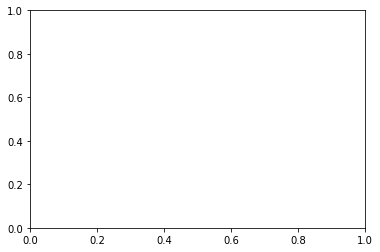

In [24]:
plt.plot(d['お参り'])

In [5]:
df_lime_short = df_lime.copy().reset_index()
for i in range(0, len(df_lime_short)):
    for j in range(15):
        df_lime_short.loc[i, f'coef{j}'] = round(float(df_lime_short.loc[i, f'coef{j}']), 3)
df_lime_short.head()

KeyboardInterrupt: 

In [ ]:
df_lime_short.to_csv('/home/yamanishi/project/trip_recommend/model/popularity_final/data/lime/lime_explain_short.csv')

In [ ]:
df_lime = pd.read_csv('/home/yamanishi/project/trip_recommend/model/popularity_final/data/lime/lime_explain_new_sage.csv')

In [ ]:
import matplotlib
import japanize_matplotlib
plt.rcParams['font.size']=18
plt.xlabel('人気度')
plt.ylabel('観光地数')
df = pd.read_csv('/home/yamanishi/project/trip_recommend/data/jalan/spot/experience_light.csv')
plt.hist(np.log10(df['review_count']))

ModuleNotFoundError: No module named 'japanize_matplotlib'

LIMEをtexに変換

In [ ]:
df_lime.head()

spot_name                 gt       pred   vocab0                coef0  \
0      spot_name                 gt       pred   vocab0                coef0   
1  東京ディズニーランド(R)  4.169556882432185  3.6517792  アトラクション   0.2856011217503848   
2   東京ディズニーシー(R)  4.042457374574321  3.6895676  アトラクション  0.32720242518621706   
3          横浜中華街  3.967875445548033  3.1488936       中華  0.16377005770490524   
4            浅草寺  3.878751520173002  3.8490665      浅草寺  0.06664845516286487   

   vocab1                coef1  vocab2                coef2  vocab3  ...  \
0  vocab1                coef1  vocab2                coef2  vocab3  ...   
1   美女と野獣  0.19263004318284058   ディズニー   0.2211598551047408    パレード  ...   
2    ソアリン                 -0.0   ディズニー  0.24814975584596308      シー  ...   
3      食べ   0.5861182763301146      横浜  0.21578914843332292      放題  ...   
4      浅草  0.24355549955081543     仲見世  0.08745969604150036      雷門  ...   

   vocab10                coef10  vocab11                 coef11  vocab12  \
0  vocab10                coef10  vocab11                 coef11  vocab12   
1       パス     0.297933353737703     待ち時間    0.08348982519060885   ファストパス   
2     ミッキー    0.1836862010966811     待ち時間    0.03973779410918411      乗り物   
3     オーダー  -0.13286652822048212      肉まん  0.0017321518241561725       点心   
4       くじ   0.10692510520723952   ライトアップ      0.287052630913094       通り   

                  coef12  vocab13               coef13  vocab14  \
0                 coef12  vocab13               coef13  vocab14   
1  -0.020843549915493222      パーク   0.1246484066383591       乗れ   
2    0.20610465836090922       パス  0.34131718919076337       入場   
3                    0.0       雑貨  0.15965010620846223       満足   
4   0.018900325903024914       着物  0.10027519237194454       お寺   

                coef14  
0               coef14  
1  0.15990037278814606  
2  0.08612321289560135  
3  0.13264957348764486  
4  0.16486973503692878  

[5 rows x 33 columns]

In [ ]:
def make_tex(index):
    spot_name = df_lime.loc[index, 'spot_name']
    tex_text = ''
    tex_text+=spot_name
    tex_text+=' '
    #print(spot_name)
    pref = spot_pref[spot_name]
    tex_text+=f'({pref}) '
    tex_text+=r'& \begin{tabular}{l}'
    df_tmp  = df_lime[df_lime['spot_name']==spot_name]
    vocabs = []
    for i in range(15):
        vocab = df_tmp.loc[index, f'vocab{i}']
        score = df_tmp.loc[index, f'coef{i}']
        vocabs.append((score, vocab))
    #print(vocabs)
    #vocabs = sorted(vocabs, reverse=False)
    vocabs.sort(key=lambda x: x[0],reverse=True)
    #print(vocabs)
    for i,(score, vocab) in enumerate(vocabs):
        tex_text+=vocab
        score = round(float(score), 3)
        tex_text+=str(score)
        tex_text+=' '
        if i==4 or i==9:
            tex_text+='\\\\'
            continue


    tex_text+="\end{tabular}\\\\ \hline"


    return tex_text

make_tex(1)

'東京ディズニーランド(R) (千葉県) & \\begin{tabular}{l}美女と野獣0.233 ショー0.179 乗り物0.173 アトラクション0.171 ファストパス0.128 \\\\ディズニー0.121 ディズニーランド0.121 キャスト0.108 乗れ0.107 パス0.105 \\\\パレード0.101 スタンバイ0.094 待ち時間0.067 ランド0.039 パーク0.038 \\end{tabular}\\\\ \\hline'

In [ ]:
-0.047>-0.02

False

In [ ]:
a=[-4,-1,-2]
a.sort()
a

[-4, -2, -1]

In [ ]:
make_tex(2)

'東京ディズニーシー(R) (千葉県) & \\begin{tabular}ソアリン0.197 ショー0.193 乗り物0.164 アトラクション0.164 ミッキー0.142 \\ディズニー0.14 ディズニーシー0.134 キャスト0.118 乗れ0.117 パス0.099 \\シー0.085 入場0.085 スタンバイ0.067 待ち時間0.061 ランド0.043 \\end{tabular}\\\\ \\hline'

In [ ]:
text = ''
for i in range(1,16):
    text+=make_tex(i)
    text+='\n'

print(text)

東京ディズニーランド(R) (千葉県) & \begin{tabular}{l}美女と野獣0.233 ショー0.179 乗り物0.173 アトラクション0.171 ファストパス0.128 \\ディズニー0.121 ディズニーランド0.121 キャスト0.108 乗れ0.107 パス0.105 \\パレード0.101 スタンバイ0.094 待ち時間0.067 ランド0.039 パーク0.038 \end{tabular}\\ \hline
東京ディズニーシー(R) (千葉県) & \begin{tabular}{l}ソアリン0.197 ショー0.193 乗り物0.164 アトラクション0.164 ミッキー0.142 \\ディズニー0.14 ディズニーシー0.134 キャスト0.118 乗れ0.117 パス0.099 \\シー0.085 入場0.085 スタンバイ0.067 待ち時間0.061 ランド0.043 \end{tabular}\\ \hline
横浜中華街 (神奈川県) & \begin{tabular}{l}中華0.217 小籠0.216 食べ0.21 歩き0.21 横浜0.186 \\飲茶0.118 料理0.103 占い0.103 雑貨0.068 肉まん0.051 \\満足0.037 放題0.0 中国0.0 オーダー0.0 点心0.0 \end{tabular}\\ \hline
浅草寺 (東京都) & \begin{tabular}{l}お参り0.17 参拝0.16 浅草0.155 雷門0.139 外国0.136 \\仲見世0.131 ライトアップ0.131 ツリー0.117 浅草寺0.113 着物0.103 \\スカイ0.09 くじ0.083 通り0.068 お寺0.033 人出-0.0 \end{tabular}\\ \hline
嚴島神社 (広島県) & \begin{tabular}{l}修繕0.177 御朱印0.151 ライトアップ0.139 宮島0.134 厳島0.12 \\鳥居0.105 大鳥居0.103 フェリー0.102 神社0.095 工事0.095 \\修復0.092 改修0.09 満潮0.051 干潮0.05 見れ0.049 \end{tabular}\\ \hline
東京駅 (東京都) & \begin{tabular}{l

In [ ]:
text = ''
for i in range(16,31):
    text+=make_tex(i)
    text+='\n'

print(text)

清水寺（京都府京都市） (京都府) & \begin{tabular}{l}参拝0.158 修学旅行0.154 拝観0.137 御朱印0.135 景色0.114 \\京都0.114 工事0.108 清水寺0.104 舞台0.093 改修0.088 \\紅葉0.081 訪れ0.074 音羽0.063 本堂0.061 清水0.053 \end{tabular}\\ \hline
キャナルシティ博多 (福岡県) & \begin{tabular}{l}買い物0.221 ショー0.174 イルミネーション0.162 博多0.153 キャナルシティ0.146 \\ショッピング0.128 キャナル0.118 映画0.109 スタジアム0.1 ラーメン0.078 \\モール0.068 プロジェクションマッピング0.067 噴水0.048 音楽0.029 福岡0.027 \end{tabular}\\ \hline
伏見稲荷大社 (京都府) & \begin{tabular}{l}外国0.327 参拝0.319 京都0.137 朱色0.134 大社0.107 \\伏見0.09 頂上0.065 山頂0.047 神社0.031 鳥居0.022 \\稲荷0.0 千本0.0 稲荷山0.0 圧巻0.0 御山-0.004 \end{tabular}\\ \hline
おかげ横丁 (三重県) & \begin{tabular}{l}食べ0.379 歩き0.343 土産0.291 おはらい0.26 横丁0.187 \\寿司0.175 伊勢神宮0.147 コロッケ0.104 伊勢0.058 うどん0.041 \\内宮0.0 福本0.0 おかげ-0.325 てこ-0.13 松坂-0.0 \end{tabular}\\ \hline
横浜赤レンガ倉庫［1号館及び2号館］ (神奈川県) & \begin{tabular}{l}ライトアップ0.225 クリスマス0.221 イベント0.207 食事0.202 ショッピング0.185 \\マーケット0.145 横浜0.142 レンガ0.131 飲食0.088 ドイツ0.04 \\煉瓦0.0 アップルパイ0.0 小物-0.02 倉庫-0.013 オクトーバーフェスト-0.0 \end{tabular}\\ \hline
アメ横 (東京都) & \begin{ta

In [11]:
from collections import defaultdict
#df_lime = pd.read_csv('/home/yamanishi/project/trip_recommend/model/popularity_final/data/lime/lime_explain_new_food.csv')[1:].reset_index()
df_lime = pd.read_csv('/home/yamanishi/project/trip_recommend/model/popularity_final/data/lime/lime_explain_new_word.csv')[118:].reset_index()
print(df_lime.head())
vocab_count = defaultdict(float)
vocab_score = defaultdict(float)
for i in range(1, 10000):
    for j in range(15):
        vocab, score = df_lime.loc[i, f'vocab{j}'], df_lime.loc[i, f'coef{j}']
        vocab_score[vocab]+=float(score)
        vocab_count[vocab]+=1

   index      spot_name        gt      pred   vocab0     coef0 vocab1  \
0    118  東京ディズニーランド(R)  4.169557  3.382752  アトラクション  0.154130  美女と野獣   
1    119   東京ディズニーシー(R)  4.042457  3.440363  アトラクション  0.150391   ソアリン   
2    120          横浜中華街  3.967875  2.817200       中華  0.207842     食べ   
3    121            浅草寺  3.878752  3.175844      浅草寺  0.128754     浅草   
4    122           嚴島神社  3.852480  3.015190       厳島  0.069750     鳥居   

      coef1 vocab2     coef2  ... vocab10    coef10 vocab11    coef11 vocab12  \
0  0.227123  ディズニー  0.143946  ...      パス  0.137209    待ち時間  0.076127  ファストパス   
1  0.190230  ディズニー  0.129529  ...    ミッキー  0.154488    待ち時間  0.056291     乗り物   
2  0.159076     横浜  0.158382  ...    オーダー -0.000000     肉まん  0.072980      点心   
3  0.159506    仲見世  0.168617  ...      くじ  0.103474  ライトアップ  0.153079      通り   
4  0.093703     工事  0.088253  ...      干潮  0.046531      見れ  0.065227      満潮   

     coef12 vocab13    coef13 vocab14    coef14  
0  0.090145     パーク  0.0

In [31]:
count=0
all=[]
for rc,spot_name, words in zip(df_exp['review_count'],df_exp['spot_name'], tfidf_top_words):
    if 'デパ' in words:
        print(spot_name, spot_to_category[spot_name])
        all.append((rc, spot_name, spot_to_category[spot_name]))
        all.sort(reverse=True)

all

伊勢丹新宿店 ['ショッピング', 'その他ショッピング']
三越日本橋本店 ['ショッピング', 'その他ショッピング']
池袋西武 ['ショッピング', 'その他ショッピング']
小田急百貨店新宿店 ['ショッピング', 'その他ショッピング']
日本橋高島屋S.C. ['ショッピング', 'その他ショッピング']
東武百貨店　池袋店 ['ショッピング', 'その他ショッピング']
京王百貨店新宿店 ['ショッピング', 'その他ショッピング']
松屋銀座 ['ショッピング', 'その他ショッピング']
ジェイアール名古屋タカシマヤ ['ショッピング', 'その他ショッピング']
名古屋三越　栄店 ['ショッピング', 'その他ショッピング']
ジェイアール京都伊勢丹 ['ショッピング', 'その他ショッピング']
阪急うめだ本店 ['ショッピング', '名産品']
阪神梅田本店 ['ショッピング', 'ショッピングセンター']
大丸梅田店 ['ショッピング', 'その他ショッピング']
大阪タカシマヤ ['ショッピング', 'ショッピングセンター']
大丸心斎橋店 ['ショッピング', 'その他ショッピング']
そごう広島店 ['ショッピング', 'その他ショッピング']
いよてつ　高島屋 ['その他', 'その他名所']


[(3106.0, '阪神梅田本店', ['ショッピング', 'ショッピングセンター']),
 (3035.0, '阪急うめだ本店', ['ショッピング', '名産品']),
 (2784.0, 'ジェイアール名古屋タカシマヤ', ['ショッピング', 'その他ショッピング']),
 (2624.0, '伊勢丹新宿店', ['ショッピング', 'その他ショッピング']),
 (1695.0, '池袋西武', ['ショッピング', 'その他ショッピング']),
 (1638.0, '大丸梅田店', ['ショッピング', 'その他ショッピング']),
 (1474.0, '三越日本橋本店', ['ショッピング', 'その他ショッピング']),
 (1202.0, '大阪タカシマヤ', ['ショッピング', 'ショッピングセンター']),
 (951.0, '京王百貨店新宿店', ['ショッピング', 'その他ショッピング']),
 (946.0, '東武百貨店\u3000池袋店', ['ショッピング', 'その他ショッピング']),
 (863.0, '小田急百貨店新宿店', ['ショッピング', 'その他ショッピング']),
 (767.0, '日本橋高島屋S.C.', ['ショッピング', 'その他ショッピング']),
 (557.0, '名古屋三越\u3000栄店', ['ショッピング', 'その他ショッピング']),
 (492.0, '大丸心斎橋店', ['ショッピング', 'その他ショッピング']),
 (459.0, 'そごう広島店', ['ショッピング', 'その他ショッピング']),
 (395.0, 'いよてつ\u3000高島屋', ['その他', 'その他名所']),
 (316.0, '松屋銀座', ['ショッピング', 'その他ショッピング']),
 (143.0, 'ジェイアール京都伊勢丹', ['ショッピング', 'その他ショッピング'])]

In [ ]:
df_exp = df_exp.sort_values(by='review_count', ascending=False)
df_exp.head()

Unnamed: 0      spot_name prefecture  \
8946         8946  東京ディズニーランド(R)        千葉県   
8945         8945   東京ディズニーシー(R)        千葉県   
40947       40947          横浜中華街       神奈川県   
9992         9992            浅草寺        東京都   
29537       29537           嚴島神社        広島県   

                                                     url  \
8946   https://www.jalan.net/kankou/spt_12227cc354006...   
8945   https://www.jalan.net/kankou/spt_12227cc354015...   
40947  https://www.jalan.net/kankou/spt_14104aj220002...   
9992   https://www.jalan.net/kankou/spt_13106ag213001...   
29537  https://www.jalan.net/kankou/spt_34327ag213001...   

                                               image_url  \
8946   https://cdn.jalan.jp/jalan/img/0/kuchikomi/038...   
8945   https://cdn.jalan.jp/jalan/img/1/kuchikomi/283...   
40947  https://cdn.jalan.jp/jalan/img/3/kuchikomi/514...   
9992   https://cdn.jalan.jp/jalan/img/4/kuchikomi/414...   
29537  https://cdn.jalan.jp/jalan/img/9/kuchikomi/032...   

                              jenre  review_rate  review_count   latitude  \
8946   エンタメ・アミューズメント,テーマパーク・レジャーランド          4.6       14776.0  35.632596   
8945   エンタメ・アミューズメント,テーマパーク・レジャーランド          4.6       11027.0  35.625675   
40947                     その他,その他名所          4.1        9287.0  35.443299   
9992           神社・神宮・寺院,その他神社・神宮・寺院          4.2        7564.0  35.714764   
29537          神社・神宮・寺院,その他神社・神宮・寺院          4.5        7120.0  34.296000   

        longitude         area   city  town  review_count_rank  valid  \
8946   139.881308  舞浜・浦安・船橋・幕張    浦安市    舞浜            42852.0      0   
8945   139.884170  舞浜・浦安・船橋・幕張    浦安市  鉄鋼通り            42851.0      6   
40947  139.645625           横浜  横浜市中区   山下町            42850.0      3   
9992   139.796731     上野・浅草・両国    台東区    浅草            42849.0      8   
29537  132.319806        広島・宮島   廿日市市   宮島町            42848.0      7   

      city_processed  
8946             浦安市  
8945             浦安市  
40947            横浜市  
9992             台東区  
29537           廿日市市

In [4]:
over10_words = dict(filter(lambda item: item[1]>=3, vocab_count.items()))
vocab_score_mean = {k:vocab_score[k]/vocab_count[k] for k in over10_words.keys()}
top50_words=sorted(vocab_score_mean.items(), key=lambda x: x[1], reverse=True)[:50]
words = ''
word_list = []
for i,(w,s) in enumerate(top50_words):
    words+=w
    words+=' '
    word_list.append(w)
    if i%10==9:
        words+='\\\\'
        words+='\n'
print(words)


有名 並ん 行列 見学 新鮮 土産 どれ 大きく 甘く 見た目 \\
可愛い 購入 素敵 買っ 焼い 濃厚 体験 ジューシー 買い 試食 \\
休憩 リーズナブル 甘い 苦手 折り返す 折々 焼き 広島 京都 折り紙 \\
買い物 たくさん 種類 安く 旭川 盛岡 抗議 ソース トロ 温泉 \\
季節 新潟 名古屋 折れ 名物 スイーツ 北海道 市場 薬味 タン \\



In [32]:
over10_words = dict(filter(lambda item: item[1]>=5, vocab_count.items()))
vocab_score_mean = {k:round(vocab_score[k]/vocab_count[k],2) for k in over10_words.keys()}
top50_words=sorted(vocab_score_mean.items(), key=lambda x: x[1], reverse=True)[:100]
words = ''
word_list = []
print(top50_words)
for i,(w,s) in enumerate(top50_words):
    words+=w
    words+=' '
    word_list.append(w)
    if i%10==9:
        words+='\\\\'
        words+='\n'
print(words)

[('買い物', 0.38), ('脱出', 0.38), ('参拝', 0.33), ('景色', 0.31), ('小籠', 0.3), ('お参り', 0.3), ('陽明', 0.3), ('平和', 0.3), ('デパ', 0.3), ('芝居', 0.3), ('ショー', 0.29), ('グリコ', 0.29), ('雰囲気', 0.29), ('見学', 0.29), ('好き', 0.29), ('勉強', 0.29), ('村塾', 0.29), ('ペンギン', 0.28), ('戦争', 0.28), ('万博', 0.28), ('楽しみ', 0.28), ('おやじ', 0.28), ('ジブリ', 0.28), ('天守閣', 0.27), ('お湯', 0.27), ('都会', 0.27), ('迫力', 0.27), ('歴史', 0.27), ('メリケン', 0.27), ('セイウチ', 0.27), ('楽しかっ', 0.27), ('散歩', 0.26), ('ハシビロコウ', 0.26), ('買い', 0.26), ('シロクマ', 0.26), ('教科書', 0.26), ('竹生島', 0.26), ('沖縄', 0.25), ('ジンベエザメ', 0.25), ('サファリ', 0.25), ('原爆', 0.25), ('五稜郭', 0.25), ('洞窟', 0.25), ('アクセス', 0.25), ('ディズニー', 0.24), ('パス', 0.24), ('飛行機', 0.24), ('天守', 0.24), ('観戦', 0.24), ('グラバー', 0.24), ('試飲', 0.24), ('流氷', 0.24), ('竹生', 0.24), ('新撰', 0.24), ('アトラクション', 0.23), ('土産', 0.23), ('水族館', 0.23), ('みなとみらい', 0.23), ('ショッピング', 0.23), ('見る', 0.23), ('博多', 0.23), ('梅田', 0.23), ('ブランド', 0.23), ('ドラマ', 0.23), ('ハチ公', 0.23), ('興味', 0.23), ('イトムカ', 0.23), ('モネ', 

In [6]:
df = pd.read_csv('/home/yamanishi/project/trip_recommend/model/popularity/data/test_result.csv')
df['pred'].max()

3.892309

In [10]:
df.sort_values('gt', ascending=False).head(10)

Unnamed: 0       spot_names        gt      pred
2194        2194            おかげ横丁  3.665769  2.739111
0              0            旭山動物園  3.649043  2.551177
1693        1693  aisorashi-アイソラシ  3.562650  1.575221
2425        2425              通天閣  3.506776  2.933635
4197        4197           関西国際空港  3.426999  2.691450
977          977             新宿御苑  3.425045  2.595507
3109        3109              松山城  3.402261  3.511837
2088        2088    えびせんべいの里　美浜本店  3.386321  1.210478
4              4           ファーム富田  3.381115  2.659954
1226        1226          新江ノ島水族館  3.363988  2.777712

In [11]:
10**2.67

467.73514128719813

In [12]:
np.log10(830)

2.9190780923760737

In [ ]:
over10_words = dict(filter(lambda item: item[1]>=3, vocab_count.items()))
vocab_score_mean = {k:vocab_score[k]/vocab_count[k] for k in over10_words.keys()}
top50_words=sorted(vocab_score_mean.items(), key=lambda x: x[1], reverse=False)[:50]
words = ''
word_list = []
print(top50_words)
for i,(w,s) in enumerate(top50_words):
    words+=w
    words+=' '
    word_list.append(w)
    if i%10==9:
        words+='\\\\'
        words+='\n'
print(words)

[('atc', -0.29369487379108833), ('間隔', -0.28292260387132184), ('築い', -0.2785682510206313), ('彦神社', -0.2666327800082182), ('小型', -0.2641134516827566), ('ikea', -0.24611720880176216), ('浮見堂', -0.23702985930444354), ('出身', -0.22182195221386192), ('pa', -0.21235440843875486), ('安全', -0.2114391152325836), ('野田線', -0.20114573092762802), ('hep', -0.20042143681942537), ('gu', -0.19986063926755784), ('藩主', -0.1987268411833712), ('sa', -0.19727622079688428), ('和山', -0.1957328606309826), ('立像', -0.19496262241612058), ('必要', -0.18875655684280232), ('five', -0.18847279472044723), ('不安', -0.18635275436242535), ('大晦', -0.1851761731717313), ('浮御堂', -0.1832496784310415), ('対策', -0.18114837459439687), ('建て', -0.18057088710046618), ('専用', -0.17518467457159037), ('猊鼻渓', -0.1747563131902045), ('おかげ', -0.17320985056999205), ('一般', -0.1707966599691277), ('限定', -0.16953434776318155), ('埼灯台', -0.16580902054898602), ('丘陵', -0.1639180076339025), ('合流', -0.16132249126507534), ('山麓', -0.16109708036424863), ('ja', 

In [ ]:
over10_words = dict(filter(lambda item: item[1]>=3, vocab_count.items()))
vocab_score_mean = {k:vocab_score[k]/vocab_count[k] for k in over10_words.keys()}
#print(sorted(vocab_score_mean.items(), key=lambda x: x[1]))
top50_words=sorted(vocab_score_mean.items(), key=lambda x: x[1])[:50]
print(top50_words)
words = ''
for i,(w,s) in enumerate(top50_words):
    words+=w
    words+=' '
    if i%10==9:
        words+='\\\\'
        words+='\n'
print(words)


[('atc', -0.29369487379108833), ('ikea', -0.2732653497184486), ('彦神社', -0.2666327800082182), ('小型', -0.2641134516827566), ('間隔', -0.2463899070786808), ('安全', -0.2442466552735289), ('浮見堂', -0.23702985930444354), ('建て', -0.23533226536764762), ('出身', -0.22182195221386192), ('藩主', -0.20605439197460154), ('hep', -0.20042143681942537), ('立像', -0.20035560849308906), ('gu', -0.19986063926755784), ('five', -0.18847279472044723), ('不安', -0.18635275436242535), ('大晦', -0.1851761731717313), ('浮御堂', -0.1832496784310415), ('対策', -0.18114837459439687), ('おかげ', -0.17320985056999205), ('山麓', -0.1714599345956222), ('専用', -0.16382928296899546), ('かん', -0.15975727459201897), ('たち', -0.15517199714549337), ('郷土', -0.15335789613698958), ('丘陵', -0.15214984581299623), ('sa', -0.15139972572183658), ('栽培', -0.15124811341867442), ('sl', -0.14376416209891477), ('限定', -0.14146590755197067), ('らん', -0.13985040650119226), ('ja', -0.13912436185982946), ('点在', -0.1374262301962132), ('vr', -0.13533085917360627), ('山陽', -

In [ ]:
df_exp.columns

Index(['Unnamed: 0', 'spot_name', 'prefecture', 'url', 'image_url', 'jenre',
       'review_rate', 'review_count', 'latitude', 'longitude', 'area', 'city',
       'town', 'review_count_rank', 'valid', 'city_processed'],
      dtype='object')

In [ ]:
df_lime = df_lime.merge(df_exp[['spot_name', 'latitude', 'longitude']], on='spot_name')

In [ ]:
#保存先　popularity_final/data/japan_pop_all.pdf
import folium
df = pd.read_csv('/home/yamanishi/project/trip_recommend/data/jalan/spot/experience_light.csv')
df['y'] = np.log10(df['review_count'])
def calc_color(score):
    return int(score/0.05)
#color={-3:'purple', -0.05:'beige', 0: 'lghtgreen',0.05:'green', 0.1:'yellow', 0.15:'orange', 0.2:'red', 0.25: 'red', 0.3:'cyan'}
color={-4:'darkblue', -3: 'purple', -2: 'blue', -1: 'lightblue', 0: 'beige', 1: 'lightgreen', 2: 'yellow', 3: 'orange',4: 'pink', 5:'lightred',6: 'red', 7:'darkred', 8: 'darkred', 9:'darkred', 10:'darkred', 11: 'darkred', 12: 'darkred'}
marker_color = {-10: 'darked',-9: 'darked',-8:'darkeblue',-7:'darkblue',-6:'cadetblue',-5: 'cadetblue', -4: 'lightblue', -3: 'purple',-2: 'darkpurple',-1:'lightgray',0:'white',1: 'beige',2:'lightgreen',3:'green',4: 'yellow',5:'orange',6:'pink', 7:'lightred', 8:'lightred', 9: 'red', 10: 'red',11:'red', 12: 'red', 13:'red', 14:'red'}
#{'white', 'darkblue', 'purple', 'darkred', 'green', 'lightgreen', 'lightblue', 'lightred', 'cadetblue', 'lightgray', 'beige', 'orange', 'pink', 'gray', 'darkpurple', 'blue', 'darkgreen', 'red', 'black'}
def visualize_word(word_list):
    map = folium.Map(location=[36, 135.5], zoom_start=5)
    for i in range(len(df_lime)):
        for j in range(15):
            if df_lime.loc[i, f'vocab{j}'] in word_list:
                score = float(df_lime.loc[i, f'coef{j}'])
                vocab = df_lime.loc[i, f'vocab{j}']
                #print(calc_color(score))
                folium.Circle(
                    location=[df_lime.loc[i, 'latitude'], df_lime.loc[i, 'longitude']],
                    radius=3,
                    color=marker_color[calc_color(score)],
                    fill=False
                ).add_to(map)
                folium.Marker(
                    location=[df_lime.loc[i, 'latitude']+1e-4*j, df_lime.loc[i, 'longitude']+1e-4*j],
                    popup=df_lime.loc[i, 'spot_name']+'\n'+vocab,
                    icon=folium.Icon(color=marker_color[calc_color(score)])
                ).add_to(map)
    return map

In [ ]:
spot_pref = {spot:pref for spot, pref in zip(df_exp['spot_name'], df_exp['prefecture'])}
def visualize_pref(pref_name):
    map = folium.Map(location=[36, 135.5], zoom_start=5)
    for i in range(len(df_lime)):
        for j in range(15):
            score = float(df_lime.loc[i, f'coef{j}'])
            vocab = df_lime.loc[i, f'vocab{j}']
            spot_name = df_lime.loc[i, 'spot_name']
            if spot_pref[spot_name]==pref_name and score>0.15:
            #print(calc_color(score))
                folium.Circle(
                    location=[df_lime.loc[i, 'latitude'], df_lime.loc[i, 'longitude']],
                    radius=3,
                    color=marker_color[calc_color(score)],
                    fill=False
                ).add_to(map)
                folium.Marker(
                    location=[df_lime.loc[i, 'latitude']+1e-3*j, df_lime.loc[i, 'longitude']+1e-3*j],
                    popup=df_lime.loc[i, 'spot_name'] + '\n' + vocab,
                    icon=folium.Icon(color=marker_color[calc_color(score)])
                ).add_to(map)
    map.save(f'{pref_name}.html')
    return map

In [ ]:
map = visualize_pref('埼玉県')
map

/home/yamanishi/.pyenv/versions/miniconda3-latest/envs/tr/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: color argument of Icon should be one of: {'black', 'lightgray', 'white', 'blue', 'darkblue', 'orange', 'darkred', 'gray', 'lightblue', 'pink', 'lightred', 'purple', 'lightgreen', 'beige', 'green', 'darkpurple', 'cadetblue', 'red', 'darkgreen'}.


In [ ]:
map = visualize_pref('東京都')
map

/home/yamanishi/.pyenv/versions/miniconda3-latest/envs/tr/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: color argument of Icon should be one of: {'black', 'lightgray', 'white', 'blue', 'darkblue', 'orange', 'darkred', 'gray', 'lightblue', 'pink', 'lightred', 'purple', 'lightgreen', 'beige', 'green', 'darkpurple', 'cadetblue', 'red', 'darkgreen'}.


In [ ]:
map = visualize_pref('京都府')
map

/home/yamanishi/.pyenv/versions/miniconda3-latest/envs/tr/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: color argument of Icon should be one of: {'black', 'lightgray', 'white', 'blue', 'darkblue', 'orange', 'darkred', 'gray', 'lightblue', 'pink', 'lightred', 'purple', 'lightgreen', 'beige', 'green', 'darkpurple', 'cadetblue', 'red', 'darkgreen'}.


In [ ]:
map = visualize_word('お参り')
map

/home/yamanishi/.pyenv/versions/miniconda3-latest/envs/tr/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: color argument of Icon should be one of: {'white', 'darkblue', 'purple', 'darkred', 'green', 'lightgreen', 'lightblue', 'lightred', 'cadetblue', 'lightgray', 'beige', 'orange', 'pink', 'gray', 'darkpurple', 'blue', 'darkgreen', 'red', 'black'}.


In [ ]:
map = visualize_word(word_list[:5])
map

/home/yamanishi/.pyenv/versions/miniconda3-latest/envs/tr/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: color argument of Icon should be one of: {'darkgreen', 'black', 'darkblue', 'red', 'beige', 'green', 'lightgray', 'cadetblue', 'blue', 'purple', 'lightblue', 'pink', 'lightgreen', 'orange', 'darkred', 'white', 'gray', 'lightred', 'darkpurple'}.


In [ ]:
df = pd.read_csv('/home/yamanishi/project/trip_recommend/model/popularity_final/data/lime/lime_explain_short.csv')

In [ ]:
def get_score(index):
    vocabs = []
    for i in range(15):
        vocabs.append([df.loc[index, f'coef{i}'], df.loc[index, f'vocab{i}']])
        vocabs.sort(reverse=True)
    words, scores = [], []
    for score, word in vocabs:
        words.append(word)
        scores.append(score)
    return words, scores

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

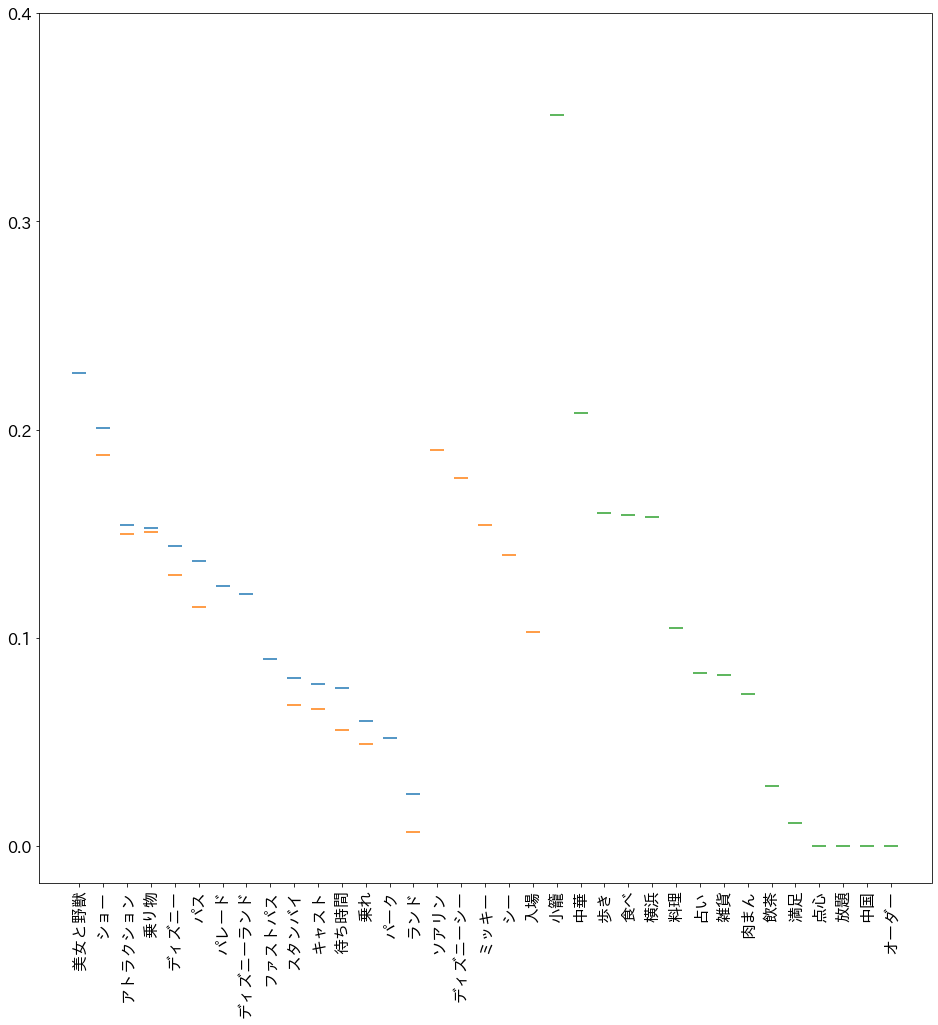

In [ ]:
import japanize_matplotlib
words0, scores0 = get_score(0)
words1, scores1 = get_score(1)
words2, scores2 = get_score(2)
plt.figure(figsize=(16, 16))
plt.rcParams['font.size'] = 16
plt.scatter(words0, scores0, marker="_", s=200)
plt.scatter(words1, scores1, marker="_", s=200)
plt.scatter(words2, scores2, marker="_", s=200)
plt.yticks(np.arange(0, 0.5, 0.1))
plt.xticks(rotation=90)

In [ ]:
df_exp = pd.read_csv('/home/yamanishi/project/trip_recommend/data/jalan/spot/experience_light.csv')

In [ ]:
s = set()
for j in df_exp['jenre']:
    j = j.split(',')
    for jj in j:
        s.add(jj)

In [ ]:
s

{'AR・VR体験',
 'BBQ/バーベキュー',
 'いちご狩り',
 'うどん・そば',
 'うどん・そば打ち',
 'お城巡り',
 'こけし絵付け',
 'さくらんぼ狩り',
 'その他',
 'その他アウトドア',
 'その他ウォータースポーツ・マリンスポーツ',
 'その他エンタメ・アミューズメント',
 'その他カフェ・スイーツ',
 'その他クラフト・工芸',
 'その他ショッピング',
 'その他スポーツ・フィットネス',
 'その他ミュージアム・ギャラリー',
 'その他レジャー・体験',
 'その他乗り物',
 'その他伝統文化',
 'その他各国料理',
 'その他名所',
 'その他果物・野菜狩り',
 'その他神社・神宮・寺院',
 'その他自然景観・絶景',
 'その他観光施設',
 'その他軽食・グルメ',
 'その他雪・スノースポーツ',
 'その他風呂・スパ・サロン',
 'ぶどう狩り',
 'みかん狩り',
 'りんご狩り',
 'わかさぎ釣り',
 'アイススケート場',
 'アウトドア',
 'アウトレットモール',
 'アクセサリー作り',
 'アスレチック(フィールドアスレチック等)',
 'アミューズメント・バー',
 'アーチェリー',
 'イタリアン・フレンチ',
 'イベント',
 'イルカウォッチング',
 'インターネットカフェ・マンガ喫茶',
 'ウィンドサーフィン',
 'ウェイクボード・ウェイクサーフィン',
 'ウォーキング・ハイキング',
 'ウォータースポーツ・マリンスポーツ',
 'ウォーターボール',
 'エステ',
 'エンタメ・アミューズメント',
 'オリエンテーリング・パーマネントコース',
 'カヌー・カヤック',
 'カフェ',
 'カフェ・スイーツ',
 'ガラス細工作り',
 'キノコ採り',
 'キャンドル作り(アロマキャンドル等)',
 'キャンプ・バンガロー・コテージ',
 'クラフト・工芸',
 'クルーズ・クルージング',
 'グラスボート',
 'ケーブルカー・ロープウェイ',
 'ゴルフ・ゴルフ場',
 'ゴーカート・公道カート',
 'サイクリング',
 'サッカー',
 'サップ・SUP(スタンドアップパドル)',
 'サバゲー(サバイバルゲーム)',
 '

Text(0, 0.5, '店数')

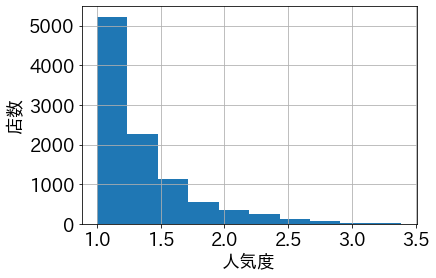

In [5]:
import japanize_matplotlib
plt.rcParams['font.size'] = 18
df_info = pd.read_csv('/home/yamanishi/project/trip_recommend/data/jalan/food/food_info_all_10000.csv')
np.log10(df_info['review_count']).hist()
plt.xlabel('人気度')
plt.ylabel('店数')

In [ ]:
review_counts = []
for j, spot_name, review_count in zip(df_exp['jenre'], df_exp['spot_name'],df_exp['review_count']):
    if '博物館' in j:
        review_counts.append((review_count, spot_name))
review_counts.sort()
for k,v in review_counts:
    print(k,v)

5.0 Y.C.M吉幾三コレクションミュージアム
5.0 【休館中】徳富記念園
5.0 あおや郷土館
5.0 いいづなアップルミュージアム
5.0 いわき市暮らしの伝承郷
5.0 うるしの里会館
5.0 えりも町郷土資料館ほろいずみ
5.0 かすみがうら市歴史博物館
5.0 きらりん館
5.0 げんでん東海テラパーク
5.0 こども陶器博物館ＫＩＤＳ・ＬＡＮＤ
5.0 すだれ資料館
5.0 つまようじ資料室
5.0 とこなめ陶の森資料館
5.0 とこなめ陶の森陶芸研究所
5.0 はにわ資料館
5.0 ひたちなか市埋蔵文化財調査センター
5.0 ふじみ野市立福岡河岸記念館
5.0 ふるさと創修館
5.0 ふれあい・学びの杜 豊後大野市資料館
5.0 ぶどうの国文化館
5.0 まきび記念館
5.0 やまこし復興交流館おらたる
5.0 ゆう・ゆう館
5.0 オホーツクミュージアムえさし
5.0 カブトガニ繁殖地
5.0 サビエル記念聖堂
5.0 タイムシップ塩竈
5.0 ディノアドベンチャー名古屋
5.0 トンボ玉工芸館
5.0 ミステリー文学資料館
5.0 ミニチュア児遊館
5.0 ミュゼふくおかカメラ館
5.0 メルシャン・ワイン資料館
5.0 一宮市木曽川資料館
5.0 七ヶ宿町水と歴史の館
5.0 三峰山博物館
5.0 三木市立金物資料館
5.0 三菱史料館
5.0 上越市立歴史博物館
5.0 下嵯峨屋
5.0 下諏訪町立諏訪湖博物館・赤彦記念館
5.0 下野薬師寺歴史館
5.0 中津川市中山道歴史資料館
5.0 中野市立博物館
5.0 仁別森林博物館
5.0 伊勢古市参宮街道資料館
5.0 伊藤公資料館
5.0 伊豆市資料館（旧中伊豆歴史民俗資料館）
5.0 作手歴史民俗資料館
5.0 信濃国分寺資料館
5.0 倉田百三文学館
5.0 億岐家住宅・宝物館
5.0 八雲町郷土資料館
5.0 六ヶ所村立郷土館
5.0 円実
5.0 出石史料館
5.0 出羽伝承館
5.0 分水良寛史料館
5.0 刈谷市郷土資料館
5.0 利府町郷土資料館
5.0 前島記念館
5.0 劇団四季記念館
5.0 勝山館跡ガイダンス施設
5.0 十和田市郷土館
5.0 十津川村むかし館
5.0 南木曽町博物館
5.0 南部杜氏伝承館
5.0 双葉の里
5.0 古保利薬師収蔵庫
5.0 古河文

In [ ]:
review_counts.sort()
